In [5]:
%load_ext autotime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import os 

import opendiff.materials as mat
import opendiff.solver as solver
import opendiff.perturbation as pert
from opendiff import set_log_level, log_level

import grid_post_process as pp

solver.init_slepc()
set_log_level(log_level.warning)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.7 ms (started: 2022-11-22 15:57:37 +01:00)


# Material creation

In [6]:
fuel1 = [[1.5, 0.01, 0, 1, 0., 0.020, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.4, 0.085, 0.135, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel1_cr = [[1.5, 0.01, 0, 1, 0., 0.020, 202 * 1.60218e-19 * 1e6, 2.4],
            [0.4, 0.130, 0.135, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel2 = [[1.5, 0.01, 0, 1, 0., 0.020, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.4, 0.080, 0.135, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
refl = [[2.0, 0.0, 0, 0, 0., 0.040, 202 * 1.60218e-19 * 1e6, 2.4],
        [0.3, 0.01, 0., 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
refl_cr = [[2.0, 0.0, 0, 0, 0., 0.040, 202 * 1.60218e-19 * 1e6, 2.4],
           [0.3, 0.055, 0., 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
void = [[1e10, 0., 0., 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4],
        [1e10, 0., 0., 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
all_mat = [fuel1, fuel1_cr, fuel2, refl, refl_cr, void]
mat_names = ["fuel1", "fuel1_cr", "fuel2", "refl", "refl_cr", "void"]
reac_names = ["D", "SIGA", "NU_SIGF", "CHI", "1", "2", "EFISS", "NU"]

mat_lib = mat.Materials(all_mat, mat_names, reac_names)

time: 27.5 ms (started: 2022-11-22 15:57:37 +01:00)


# Geometry and macrolib creation 

In [7]:
x = [0, 20*9]
y = [0, 20*9]
z_delta = [0, 20., 260, 80, 20]
z = np.cumsum(z_delta)
pblm3 = np.array([ ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",    "refl"],
                ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",    "refl"],
                ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",    "refl"],
                ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",    "refl"],
                ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",    "void"],
                ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",    "void"],
                ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "void",     "void",    "void"],
                ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "void",     "void",    "void"],
                ["refl",     "refl",     "refl",     "refl",     "void",     "void",     "void",     "void",    "void"]])
pblm2 = np.array([ ["fuel1_cr", "fuel1",    "fuel1",    "fuel1",    "fuel1_cr", "fuel1",    "fuel1",    "fuel2",   "refl"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel2",   "refl"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel2",    "fuel2",   "refl"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel2",    "refl",    "refl"],
                ["fuel1_cr", "fuel1",    "fuel1",    "fuel1",    "fuel1_cr", "fuel2",    "fuel2",    "refl",    "void"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel2",    "fuel2",    "refl",     "refl",    "void"],
                ["fuel1",    "fuel1",    "fuel2",    "fuel2",    "fuel2",    "refl",     "refl",     "void",    "void"],
                ["fuel2",    "fuel2",    "fuel2",    "refl",     "refl",     "refl",     "void",     "void",    "void"],
                ["refl",     "refl",     "refl",     "refl",     "void",     "void",     "void",     "void",    "void"]])
pblm1 = np.array([ ["fuel1_cr", "fuel1",    "fuel1",    "fuel1",    "fuel1_cr", "fuel1",    "fuel1",    "fuel2",   "refl"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel2",   "refl"],
                ["fuel1",    "fuel1",    "fuel1_cr", "fuel1",    "fuel1",    "fuel1",    "fuel2",    "fuel2",   "refl"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel2",    "refl",    "refl"],
                ["fuel1_cr", "fuel1",    "fuel1",    "fuel1",    "fuel1_cr", "fuel2",    "fuel2",    "refl",    "void"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel2",    "fuel2",    "refl",     "refl",    "void"],
                ["fuel1",    "fuel1",    "fuel2",    "fuel2",    "fuel2",    "refl",     "refl",     "void",    "void"],
                ["fuel2",    "fuel2",    "fuel2",    "refl",     "refl",     "refl",     "void",     "void",    "void"],
                ["refl",     "refl",     "refl",     "refl",     "void",     "void",     "void",     "void",    "void"]])
pblm0 = np.array([ ["refl_cr",  "refl",     "refl",     "refl",     "refl_cr",  "refl",     "refl",     "refl",    "refl"],
                ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",    "refl"],
                ["refl",     "refl",     "refl_cr",  "refl",     "refl",     "refl",     "refl",     "refl",    "refl"],
                ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",    "refl"],
                ["refl_cr",  "refl",     "refl",     "refl",     "refl_cr",  "refl",     "refl",     "refl",    "void"],
                ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",    "void"],
                ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "void",    "void"],
                ["refl",     "refl",     "refl",     "refl",     "refl",     "refl",     "void",     "void",    "void"],
                ["refl",     "refl",     "refl",     "refl",     "void",     "void",     "void",     "void",    "void"]])
#we mesh it
pblm = []
nb_div_pmat_x = 5
nb_div_pmat_y = 5
z_mesh = [[0., 5, 10, 13, 16, 18, 19, 20.],
        [21, 22, 24, 27, 30., 35, 40, 50, 60, 70, 80, 90, 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200.,
        210, 220, 230, 240, 250, 260, 265, 270., 273, 276, 278, 279, 280],
        [281, 282, 284, 287, 300, 305, 310, 320, 330, 340, 345, 350, 353, 356, 358, 359, 360], 
        [361, 362, 364, 367, 370, 375, 380.]]
z_mesh_r = z_mesh
for pblm_i, z_mesh_i in zip([pblm3, pblm2, pblm1, pblm0], z_mesh_r):
    shape = (1, pblm_i.shape[0]*nb_div_pmat_y, pblm_i.shape[1]*nb_div_pmat_x)
    geom = np.empty(shape, dtype='U16')
    for i, row in enumerate(pblm_i):
        for j, value in enumerate(row):
            geom[0, i*nb_div_pmat_x:(i+1)*nb_div_pmat_x, j *
                nb_div_pmat_y:(j+1)*nb_div_pmat_y] = value
    for k in range(len(z_mesh_i)):
        if z_mesh_i[k] == 0.:
            continue
        pblm.append(geom)
pblm = np.concatenate(pblm, axis=0)
x_mesh = np.linspace(x[0], x[1], pblm.shape[2]+1)
dx = x_mesh[1:]-x_mesh[:-1]
y_mesh = np.linspace(y[0], y[1], pblm.shape[1]+1)
dy = y_mesh[1:]-y_mesh[:-1]
z_mesh = np.array([y for x in z_mesh_r for y in x])
dz = z_mesh[1:]-z_mesh[:-1]
macrolib = mat.Macrolib(mat_lib, pblm)

time: 4.07 s (started: 2022-11-22 15:57:37 +01:00)


# Solver creation

In [8]:
s = solver.SolverFullSlepc(x_mesh, y_mesh, z_mesh,
                       macrolib, 1., 0., 1., 0., 0., 0.)
s_star = solver.SolverFullSlepc(s)
s_star.makeAdjoint()

time: 9.38 s (started: 2022-11-22 15:57:42 +01:00)


# Solve the problem

In [ ]:
# s.solve(tol=1e-15, nb_eigen_values=200, inner_max_iter=10, tol_inner=1e-3)
# s_star.solve(tol=1e-15, nb_eigen_values=200, inner_max_iter=10, tol_inner=1e-3)

path_s = "./aiea_3d.h5"
path_s_star = "./aiea_3d_star.h5"
if os.path.exists(path_s):
    s.load(path_s)
    s_star.load(path_s_star)
else:
    s.solve(tol=1e-15, nb_eigen_values=1500, inner_max_iter=100, tol_inner=1e-4)
    s_star.solve(tol=1e-15, nb_eigen_values=1500, inner_max_iter=100, tol_inner=1e-4)
    s.dump(path_s)
    s_star.dump(path_s_star)

nb_ev = 200
s.removeEigenVectors(list(range(nb_ev, 1501)))
s_star.removeEigenVectors(list(range(nb_ev, 1501)))

egval = s.getEigenValues()

egval = s.getEigenValues()

# Visualisation of the direct flux 

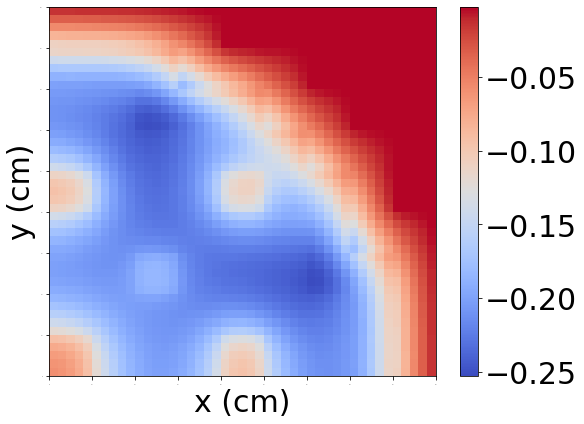

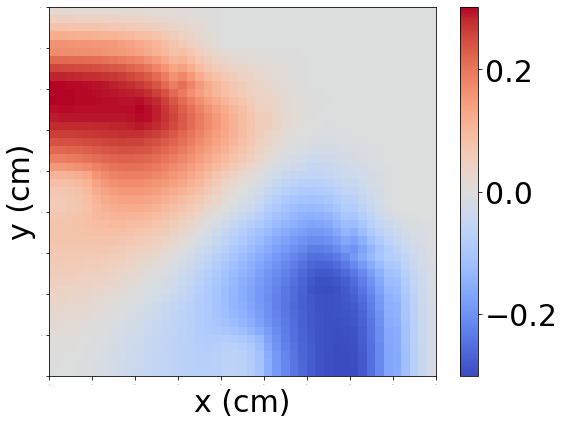

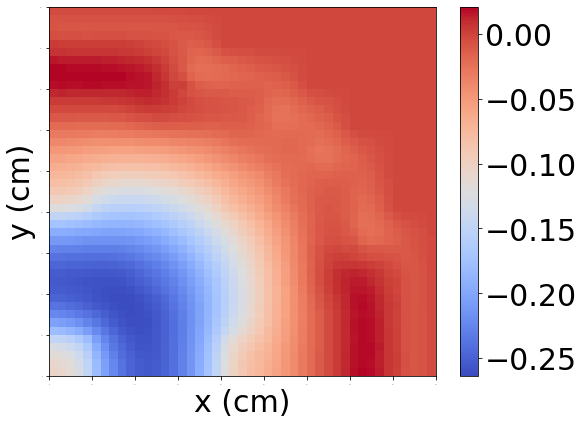

time: 648 ms (started: 2022-09-28 10:58:51 +02:00)


In [ ]:
ev0 = s.getEigenVector(0)
pp.plot_map2d(ev0.sum(axis=0).sum(axis=0), [x_mesh, y_mesh], show_stat_data=False, show_edge=False, show=True)

ev1 = s.getEigenVector(1)
pp.plot_map2d(ev1.sum(axis=0).sum(axis=0), [x_mesh, y_mesh], show_stat_data=False, show_edge=False, show=True)

ev2 = s.getEigenVector(2)
pp.plot_map2d(ev2.sum(axis=0).sum(axis=0), [x_mesh, y_mesh], show_stat_data=False, show_edge=False, show=True)

# Visualisation of the adjoint flux 

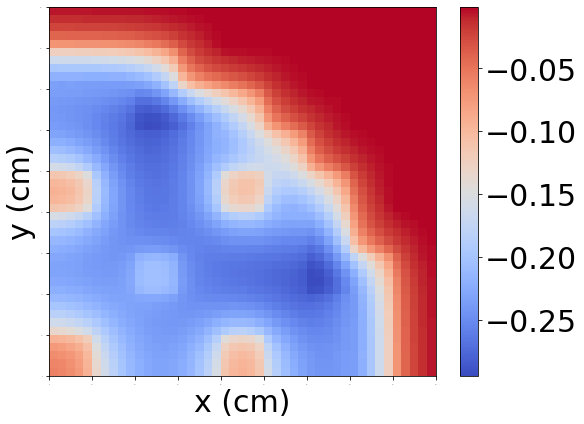

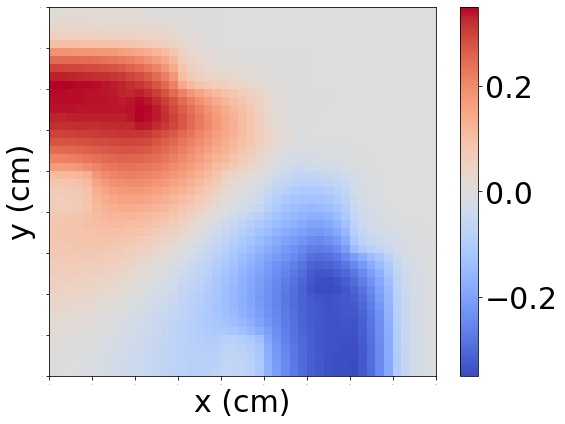

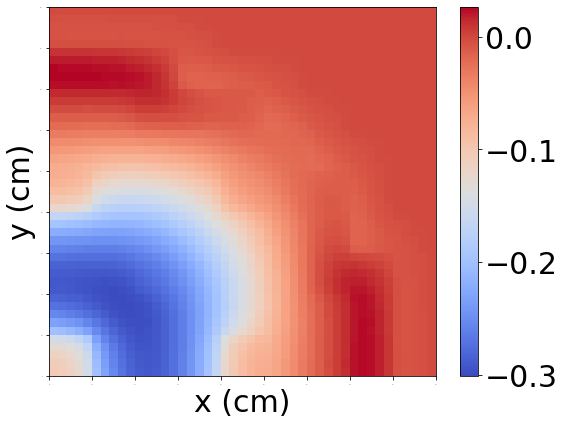

time: 553 ms (started: 2022-09-28 10:58:51 +02:00)


In [ ]:
ev0 = s_star.getEigenVector(0)
pp.plot_map2d(ev0.sum(axis=0).sum(axis=0), [x_mesh, y_mesh], show_stat_data=False, show_edge=False, show=True)

ev1 = s_star.getEigenVector(1)
pp.plot_map2d(ev1.sum(axis=0).sum(axis=0), [x_mesh, y_mesh], show_stat_data=False, show_edge=False, show=True)

ev2 = s_star.getEigenVector(2)
pp.plot_map2d(ev2.sum(axis=0).sum(axis=0), [x_mesh, y_mesh], show_stat_data=False, show_edge=False, show=True)

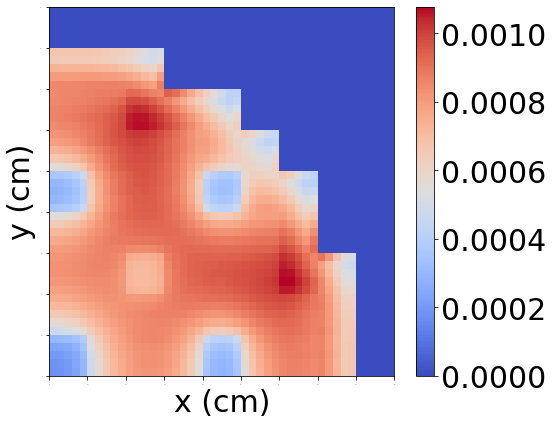

time: 306 ms (started: 2022-09-28 10:58:52 +02:00)


In [ ]:
power = s.normPower()
pp.plot_map2d(power.sum(axis=0), [x_mesh, y_mesh], show_stat_data=False, show_edge=False, show=True)

# Check biorthogonality and degenerated ev

In [ ]:
set_log_level(log_level.info)
s.normPhiStarMPhi(s_star)
pert.checkBiOrthogonality(s, s_star, 1e-5, False)

False

time: 1min 40s (started: 2022-09-28 10:58:52 +02:00)


# First order modal expansion reconstruction  


## Removal op pertubation

In [ ]:
mat_lib_pert = mat.Materials(mat_lib)
sigr = mat_lib_pert.getValue("fuel1_cr", 1, "SIGR")*1.01
mat_lib_pert.setValue("fuel1_cr", 1, "SIGR", sigr)

macrolib_pert = mat.Macrolib(mat_lib_pert, pblm)
s_pert_removal = solver.SolverFullSlepc(x_mesh, y_mesh, z_mesh,
                            macrolib_pert, 1., 0., 1., 0., 0., 0.)
s_pert_removal.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_removal = solver.SolverFullSlepc(s_pert_removal)

time: 5min 31s (started: 2022-09-28 11:00:33 +02:00)


In [ ]:
_, _, a_removal = pert.firstOrderPerturbation(
    s, s_star, s_recons_removal, "PhiStarMPhi")

time: 4.13 s (started: 2022-09-28 11:06:04 +02:00)


a0 =  0.9998556690716477


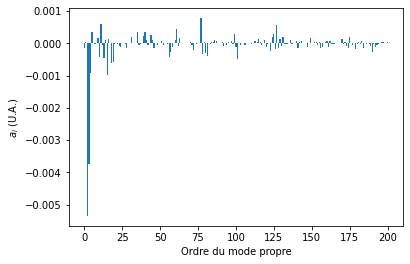

time: 883 ms (started: 2022-09-28 11:06:08 +02:00)


In [ ]:
def plot_recons_coeff(a):
    print("a0 = ", a[0])
    a[0] -= 1
    fig, ax = plt.subplots()
    y_pos = np.arange(len(a))
    ax.bar(y_pos, a)
    ax.set_xlabel("Ordre du mode propre")
    ax.set_ylabel("$a_i$ (U.A.)")
    plt.show()
    
plot_recons_coeff(a_removal)

vp recons =  1.0211217182064471
vp pert =  1.0211260850956119
vp ref =  1.021416562207763
sens -27.850285531239287
sens recons -28.269093836495802
delta recons -0.4188083052565187
pert/ref - 1 (min, max) :  -4.970450950441749 1.2745774451066803 -0.334699428398191 0.9097174522603357
recons/pert - 1 (min, max) :  -1.6380714645475665 2.3367759874788803 0.008892710583324437 0.22459425116997497
pert_2d/ref_2d - 1 (min, max) :  -3.0939986078872255 0.8846782339145979 0.0510549567611143 0.6316224016352214
recons_2d/ref_2d - 1 (min, max) :  -0.17630184591681972 1.4209520702824165 0.02356249270389317 0.17161619412593102
power pert/ref - 1 (min, max) :  -4.862071684544088 1.269193807441741 -0.52604127904102 0.9467518389151405
power recons/pert - 1 (min, max) :  -1.4608745958977625 2.2813661402510452 0.027498209665226734 0.24371661631875477
power pert_2d/ref_2d - 1 (min, max) :  -3.037210511397603 0.8755732843538269 -0.08580669727200063 0.7098729755951122
power recons_2d/ref_2d - 1 (min, max) :  -

/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


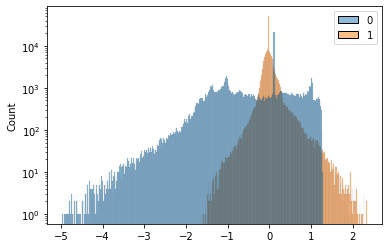

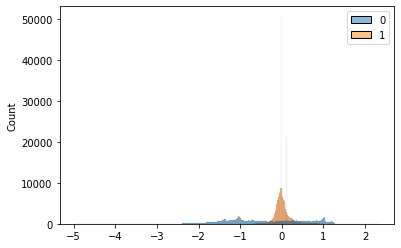

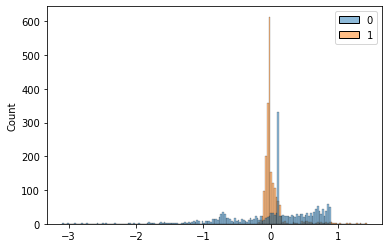

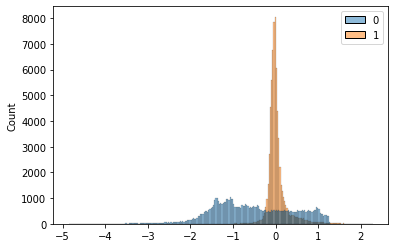

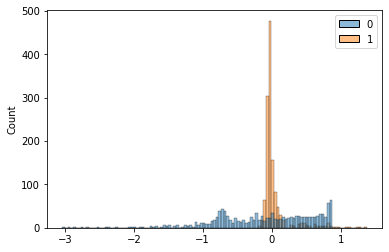

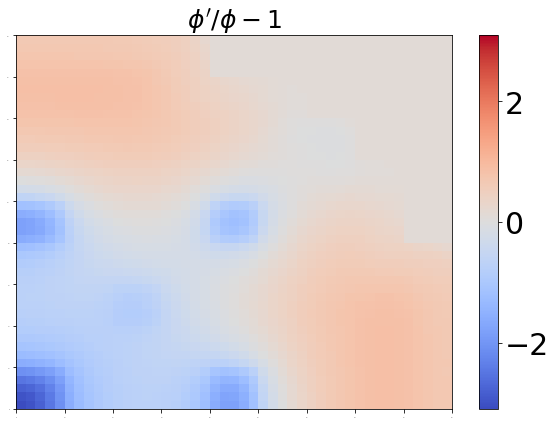

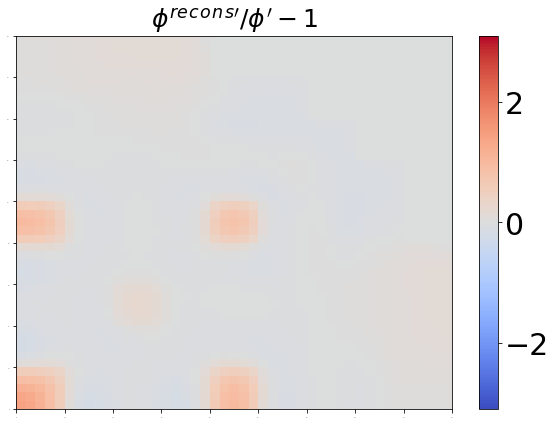

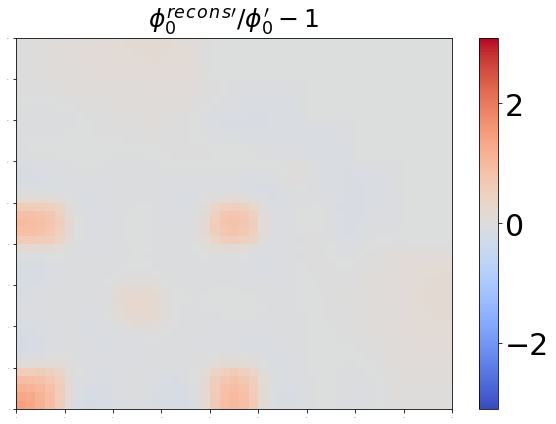

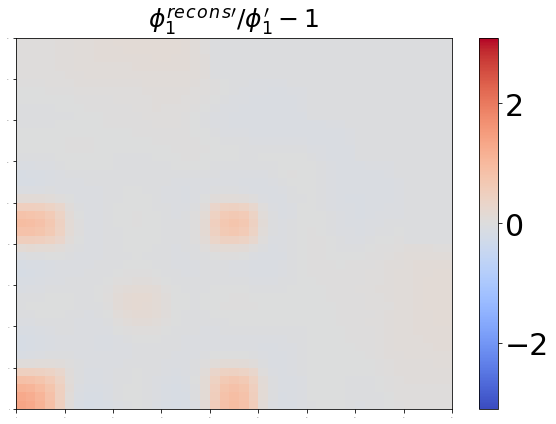

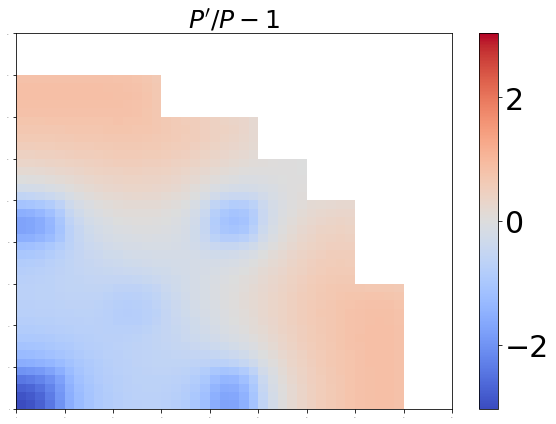

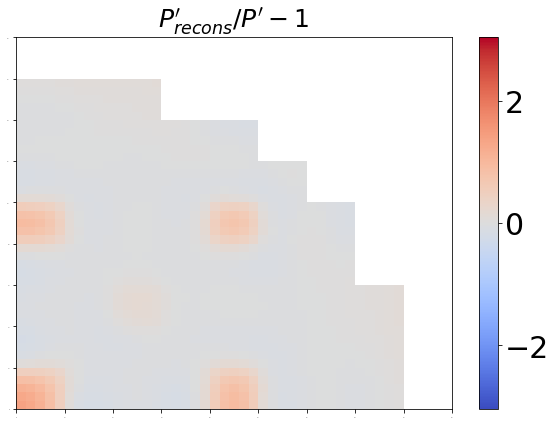

time: 9.29 s (started: 2022-09-28 11:06:09 +02:00)


In [ ]:
def plot_delta(s, s_recons, s_pert):
    egval_recons = s_recons.getEigenValues()
    egval_pert = s_pert.getEigenValues()
    egval = s.getEigenValues()
    print("vp recons = ", egval_recons[0])
    print("vp pert = ", egval_pert[0])
    print("vp ref = ", egval[0])

    print("sens", 1e5*(egval_pert[0]-egval[0])/(egval[0]*egval_pert[0]))
    print("sens recons", 1e5 *
          (egval_recons[0]-egval[0])/(egval[0]*egval_recons[0]))
    print("delta recons", 1e5 *
          (egval_recons[0]-egval_pert[0])/(egval_pert[0]*egval_recons[0]))

    power_pert = s_pert.normPower()
    power = s.normPower()
    power_recons = s_recons.normPower()

    ev0 = s.getEigenVector(0)
    ev0_recons = s_recons.getEigenVector(0)
    ev0_pert = s_pert.getEigenVector(0)

    ev0_2d = ev0.sum(axis=0).sum(axis=0)
    ev0_recons_2d = ev0_recons.sum(axis=0).sum(axis=0)
    ev0_pert_2d = ev0_pert.sum(axis=0).sum(axis=0)

    power_2d = power.sum(axis=0)
    power_recons_2d = power_recons.sum(axis=0)
    power_pert_2d = power_pert.sum(axis=0)

    delta = 100*(ev0_pert-ev0)/ev0
    delta_recons = 100*(ev0_recons-ev0_pert)/ev0_pert

    ev0_norm = ev0 / np.nansum(ev0)
    ev0_pert_norm = ev0_pert / np.nansum(ev0_pert)
    ev0_recons_norm = ev0_recons / np.nansum(ev0_recons)
    ev0_pert_re = np.nansum(ev0_norm*np.log(ev0_norm/ev0_pert_norm))
    ev0_recons_re = np.nansum(ev0_pert_norm*np.log(ev0_pert_norm/ev0_recons_norm))


    delta_2d = 100*(ev0_pert_2d-ev0_2d)/ev0_2d
    delta_recons_2d = 100*(ev0_recons_2d-ev0_pert_2d)/ev0_pert_2d

    ev0_norm_2d = ev0_2d / np.nansum(ev0_2d)
    ev0_pert_norm_2d = ev0_pert_2d / np.nansum(ev0_pert_2d)
    ev0_recons_norm_2d = ev0_recons_2d / np.nansum(ev0_recons_2d)
    ev0_pert_re_2d = np.nansum(ev0_norm_2d*np.log(ev0_norm_2d/ev0_pert_norm_2d))
    ev0_recons_re_2d = np.nansum(ev0_pert_norm_2d*np.log(ev0_pert_norm_2d/ev0_recons_norm_2d))


    delta_power = 100*(power_pert-power)/power
    delta_recons_power = 100*(power_recons-power_pert)/power_pert

    power_norm = power[~np.isnan(power)] / np.nansum(power)
    power_pert_norm = power_pert[~np.isnan(power_pert)] / np.nansum(power_pert)
    power_recons_norm = power_recons[~np.isnan(
        power_recons)] / np.nansum(power_recons)
    power_pert_re = np.nansum(power_norm*np.log(power_norm/power_pert_norm))
    power_recons_re = np.nansum(power_pert_norm*np.log(power_pert_norm/power_recons_norm))

    delta_2d_power = 100*(power_pert_2d-power_2d)/power_2d
    delta_recons_2d_power = 100*(power_recons_2d-power_pert_2d)/power_pert_2d

    power_norm_2d = power_2d[~np.isnan(power_2d)] / np.nansum(power_2d)
    power_pert_norm_2d = power_pert_2d[~np.isnan(power_pert_2d)] / np.nansum(power_pert_2d)
    power_recons_norm_2d = power_recons_2d[~np.isnan(
        power_recons_2d)] / np.nansum(power_recons_2d)
    power_pert_re_2d = np.nansum(power_norm_2d*np.log(power_norm_2d/power_pert_norm_2d))
    power_recons_re_2d = np.nansum(power_pert_norm_2d*np.log(power_pert_norm_2d/power_recons_norm_2d))

    print("pert/ref - 1 (mean, std, min, max, relative entropy) : ",
          np.mean(delta), np.std(delta), np.min(delta), np.max(delta), ev0_pert_re)
    print("recons/pert - 1 (mean, std, min, max, relative entropy) : ", np.mean(delta_recons),
          np.std(delta_recons), np.min(delta_recons), np.max(delta_recons), ev0_recons_re)
    print("pert_2d/ref_2d - 1 (mean, std, min, max, relative entropy) : ",
          np.mean(delta_2d), np.std(delta_2d), np.min(delta_2d), np.max(delta_2d), ev0_pert_re_2d)
    print("recons_2d/pert_2d - 1 (mean, std, min, max, relative entropy) : ", np.mean(delta_recons_2d),
          np.std(delta_recons_2d), np.min(delta_recons_2d), np.max(delta_recons_2d), ev0_recons_re_2d)

    print("power pert/ref - 1 (mean, std, min, max, relative entropy) : ", np.nanmean(delta_power),
          np.nanstd(delta_power), np.nanmin(delta_power), np.nanmax(delta_power), power_pert_re)
    print("power recons/pert - 1 (mean, std, min, max, relative entropy) : ", np.nanmean(delta_recons_power),
          np.nanstd(delta_recons_power), np.nanmin(delta_recons_power), np.nanmax(delta_recons_power), power_recons_re)
    print("power pert_2d/ref_2d - 1 (mean, std, min, max, relative entropy) : ", np.nanmean(delta_2d_power),
          np.nanstd(delta_2d_power), np.nanmin(delta_2d_power), np.nanmax(delta_2d_power), power_pert_re_2d)
    print("power recons_2d/pert_2d - 1 (mean, std, min, max, relative entropy) : ", np.nanmean(delta_recons_2d_power),
          np.nanstd(delta_recons_2d_power), np.nanmin(delta_recons_2d_power), np.nanmax(delta_recons_2d_power), power_recons_re_2d)

    sns.histplot([delta.flatten(), delta_recons.flatten()],
                 log_scale=(False, True))
    plt.show()
    sns.histplot([delta.flatten(), delta_recons.flatten()])
    plt.show()

    sns.histplot([delta_2d.flatten(), delta_recons_2d.flatten()])
    plt.show()

    sns.histplot([delta_power.flatten(), delta_recons_power.flatten()])
    plt.show()

    sns.histplot([delta_2d_power.flatten(), delta_recons_2d_power.flatten()])
    plt.show()

    max_delta = np.max(np.abs(delta_2d))
    pp.plot_map2d(delta_2d,
                  [x_mesh, y_mesh], show=True, x_label=None, y_label=None, cbar=True, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                  title="$\phi'/\phi - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en")

    pp.plot_map2d(delta_recons_2d,
                  [x_mesh, y_mesh], show=True, x_label=None, y_label=None, cbar=True, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                  title="$\phi^{recons}'/\phi' - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en")
    pp.plot_map2d(100*(ev0_recons[:, :, :, 0].sum(axis=0)-ev0_pert[:, :, :, 0].sum(axis=0))/ev0_pert[:, :, :, 0].sum(axis=0), [x_mesh, y_mesh],
                  show=True, x_label=None, y_label=None, cbar=True, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                  title="$\phi_0^{recons}'/\phi_0' - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en")
    pp.plot_map2d(100*(ev0_recons[:, :, :, 1].sum(axis=0)-ev0_pert[:, :, :, 1].sum(axis=0))/ev0_pert[:, :, :, 1].sum(axis=0), [x_mesh, y_mesh],
                  show=True, x_label=None, y_label=None, cbar=True, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                  title="$\phi_1^{recons}'/\phi_1' - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en")

    max_delta = np.nanmax(np.abs(delta_2d_power))
    pp.plot_map2d(delta_2d_power,
                  [x_mesh, y_mesh], show=True, x_label=None, y_label=None, cbar=True, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                  title="$P'/P - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en")

    pp.plot_map2d(delta_recons_2d_power,
                  [x_mesh, y_mesh], show=True, x_label=None, y_label=None, cbar=True, show_stat_data=False, show_edge=False, show_xy=False, sym=True, stat_data_size=12,
                  title="$P_{recons}'/P' - 1$", vmin=-max_delta, vmax=max_delta, stat_lang="en")
    
    return ev0_recons_re/ev0_pert_re,  power_recons_re/power_pert_re, delta, delta_power

re_sigr,  re_power_sigr, delta_sigr, delta_power_sigr, delta_recons_sigr, delta_recons_power_sigr = plot_delta(s, s_recons_removal, s_pert_removal)

## Fuel xs perturbation 

In [ ]:
mat_lib_pert = mat.Materials(mat_lib)
sigf = mat_lib_pert.getValue("fuel1", 2, "NU_SIGF")*1.01
mat_lib_pert.setValue("fuel1", 2, "NU_SIGF", sigf)

macrolib_pert = mat.Macrolib(mat_lib_pert, pblm)
s_pert_fiss = solver.SolverFullSlepc(x_mesh, y_mesh, z_mesh,
                            macrolib_pert, 1., 0., 1., 0., 0., 0.)
s_pert_fiss.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_fiss = solver.SolverFullSlepc(s_pert_fiss)

[2022-09-28 11:06:19.796] [debug] Solver : krylovschur
[2022-09-28 11:06:19.796] [debug] Inner solver : 
[2022-09-28 11:06:19.796] [debug] Inner precond : 
[2022-09-28 11:06:19.796] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-09-28 11:06:19.797] [debug] Tolerance in inner iteration : 1.00e-03
[2022-09-28 11:06:19.797] [debug] Max. outer iteration : 500
[2022-09-28 11:06:19.797] [debug] Max. inner iteration : 10
[2022-09-28 11:11:56.149] [info] Number of converged eigenpairs: 1
[2022-09-28 11:11:56.150] [debug] Number of outter iteration: 10
[2022-09-28 11:11:56.150] [debug] Slepc converged reason: tolerance
[2022-09-28 11:11:56.163] [info] Eigen value 0 = 1.02906 +- 6.87e-06
time: 5min 37s (started: 2022-09-28 11:06:18 +02:00)


a0 =  1.0


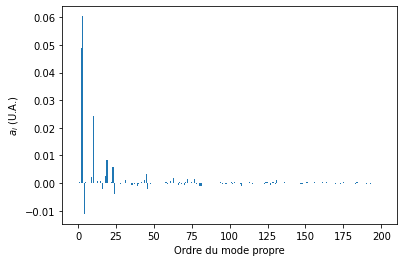

vp recons =  1.0288293608349448
vp pert =  1.029061728454242
vp ref =  1.021416562207763
sens 727.3486068041423
sens recons 705.4008149915361
delta recons -21.9477918126062
pert/ref - 1 (min, max) :  -16.03786982476979 14.082081829131601 -1.5546338450769337 7.875322773396844
recons/pert - 1 (min, max) :  -2.9591769210702985 3.3015355929337784 0.10195037103017732 0.6492768689813797
pert_2d/ref_2d - 1 (min, max) :  -11.44840554157776 11.170075986997787 -3.601833924555406 7.152476371619206
recons_2d/ref_2d - 1 (min, max) :  -0.9269675246840646 1.6185388492838053 -0.11380151159755078 0.3625142180010286
power pert/ref - 1 (min, max) :  -15.907707660127077 15.183202441702743 2.1873089387692493 7.813068062141454
power recons/pert - 1 (min, max) :  -2.69449334573689 3.0702544856202274 0.22632600591555646 0.573759506318255
power pert_2d/ref_2d - 1 (min, max) :  -11.251635939127503 12.26839070565881 -0.05065590967762546 7.792799580091272
power recons_2d/ref_2d - 1 (min, max) :  -0.85891721767600

/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


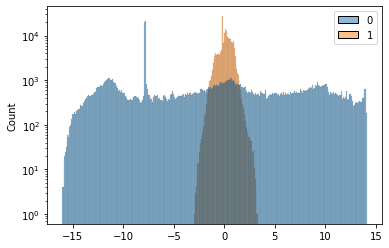

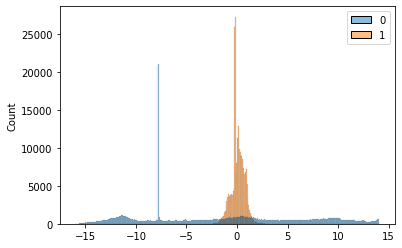

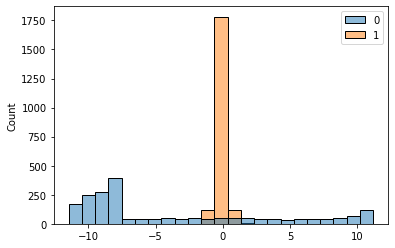

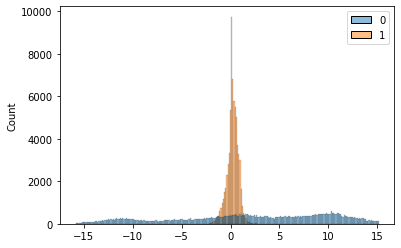

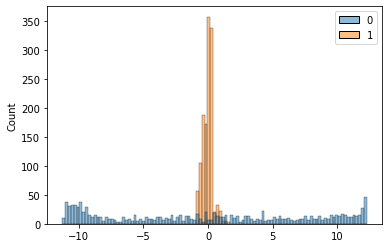

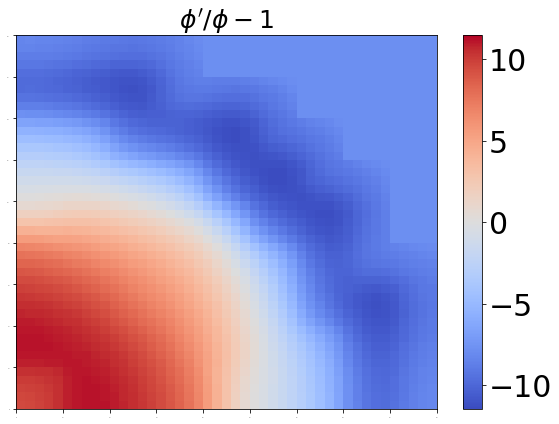

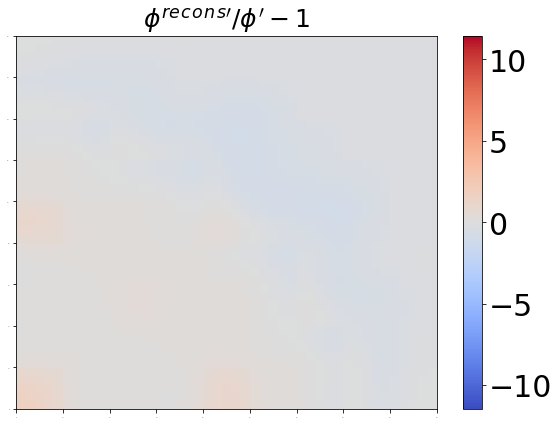

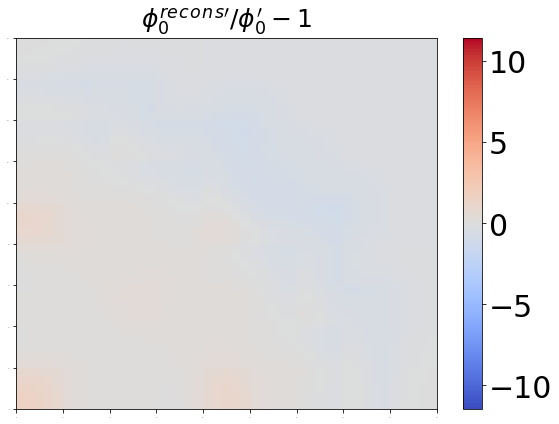

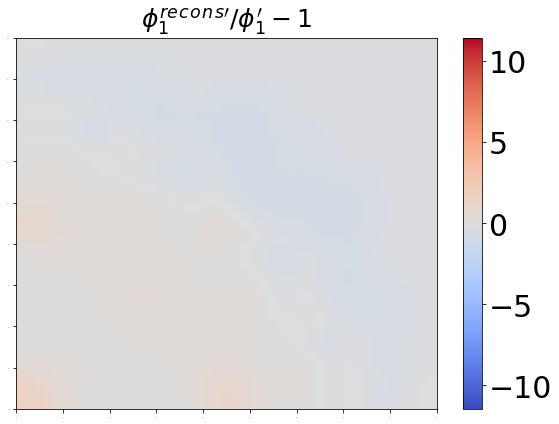

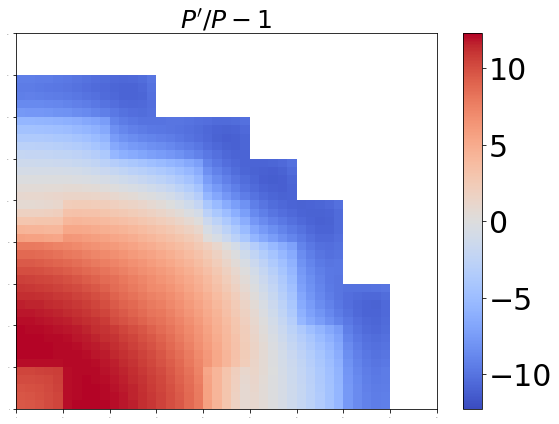

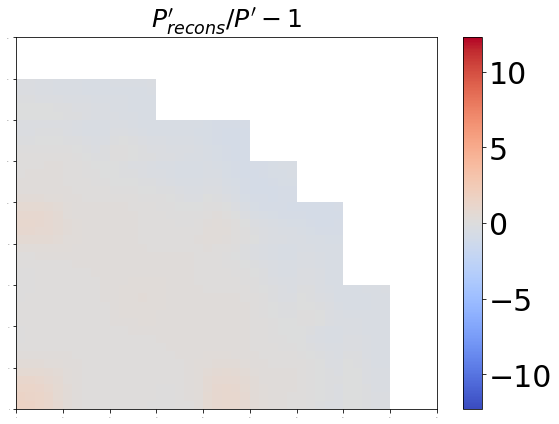

time: 11.3 s (started: 2022-09-28 11:11:56 +02:00)


In [ ]:
set_log_level(log_level.debug)
egvec_recons, egval_recons, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_fiss, "PhiStarMPhi")

plot_recons_coeff(a)
re_sigf,  re_power_sigf, delta_sigf, delta_power_sigf, delta_recons_sigf, delta_recons_power_sigf = plot_delta(s, s_recons_fiss, s_pert_fiss)

## Refl xs perturbation 

In [ ]:
mat_lib_pert = mat.Materials(mat_lib)
sigf = mat_lib_pert.getValue("refl", 1, "SIGA")*1.01
mat_lib_pert.setValue("refl", 1, "SIGA", sigf)

macrolib_pert = mat.Macrolib(mat_lib_pert, pblm)
s_pert_refl = solver.SolverFullSlepc(x_mesh, y_mesh, z_mesh,
                            macrolib_pert, 1., 0., 1., 0., 0., 0.)
s_pert_refl.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_refl = solver.SolverFullSlepc(s_pert_refl)

time: 6min 6s (started: 2022-09-28 11:12:07 +02:00)[2022-09-28 11:12:08.338] [debug] Solver : krylovschur
[2022-09-28 11:12:08.338] [debug] Inner solver : 
[2022-09-28 11:12:08.338] [debug] Inner precond : 
[2022-09-28 11:12:08.338] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-09-28 11:12:08.338] [debug] Tolerance in inner iteration : 1.00e-03
[2022-09-28 11:12:08.338] [debug] Max. outer iteration : 500
[2022-09-28 11:12:08.338] [debug] Max. inner iteration : 10
[2022-09-28 11:18:13.634] [info] Number of converged eigenpairs: 1
[2022-09-28 11:18:13.634] [debug] Number of outter iteration: 10
[2022-09-28 11:18:13.634] [debug] Slepc converged reason: tolerance
[2022-09-28 11:18:13.658] [info] Eigen value 0 = 1.02142 +- 6.89e-06



a0 =  1.0


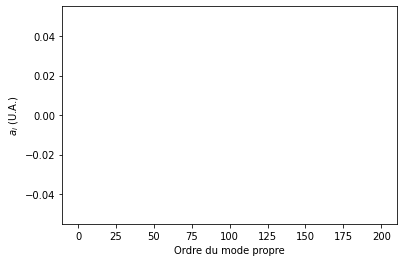

vp recons =  1.021416562207763
vp pert =  1.0214165622077556
vp ref =  1.021416562207763
sens -7.023415700009134e-10
sens recons 0.0
delta recons 7.023415700009134e-10
pert/ref - 1 (min, max) :  -5.143943308769929e-11 2.9567490895579605e-09 1.5631326618717668e-11 4.8239735421450075e-11
recons/pert - 1 (min, max) :  -2.9567490894705366e-09 5.1439433087725756e-11 -1.563132661869196e-11 4.8239735420953114e-11
pert_2d/ref_2d - 1 (min, max) :  -2.0822520367448086e-12 1.2106802946834356e-11 2.0012131073229895e-12 4.47537308636715e-12
recons_2d/ref_2d - 1 (min, max) :  -1.2106802946832889e-11 2.0822520367448523e-12 -2.0012131073227487e-12 4.475373086366665e-12
power pert/ref - 1 (min, max) :  -2.0878063180926717e-11 1.3069979318527675e-10 9.316355072189859e-12 1.8675646026654523e-11
power recons/pert - 1 (min, max) :  -1.306997931851059e-10 2.0878063180931076e-11 -9.3163550721855e-12 1.8675646026644858e-11
power pert_2d/ref_2d - 1 (min, max) :  -1.9973723536595344e-12 4.602024669915978e-12 8.

/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


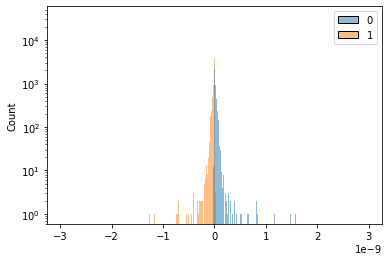

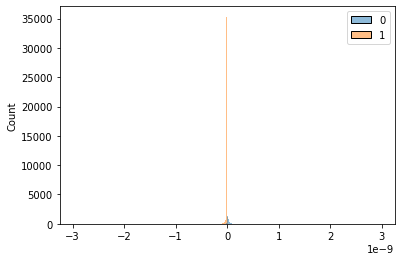

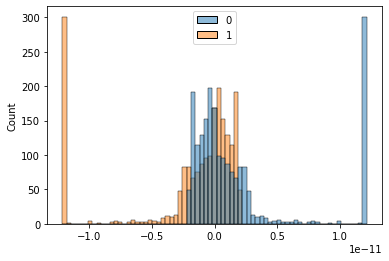

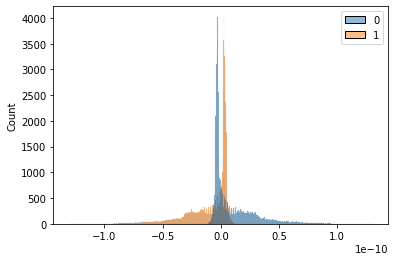

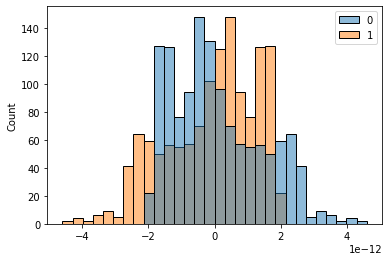

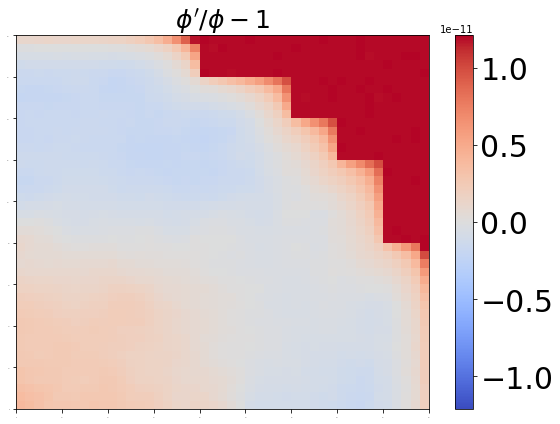

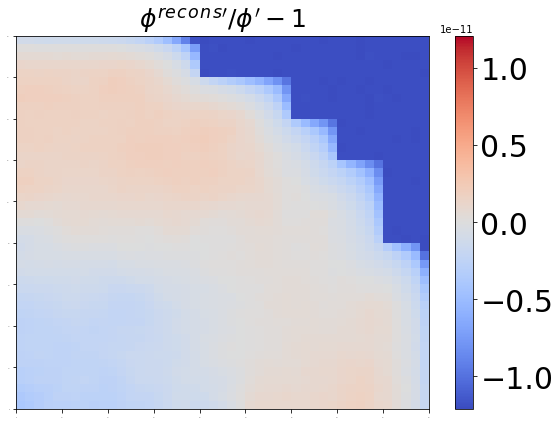

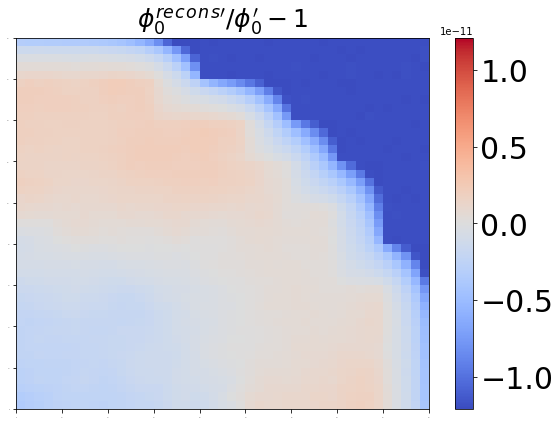

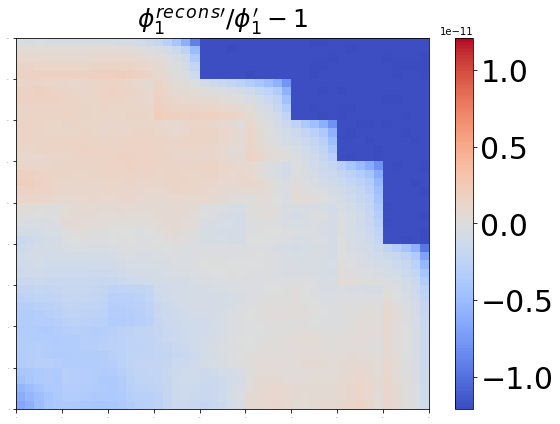

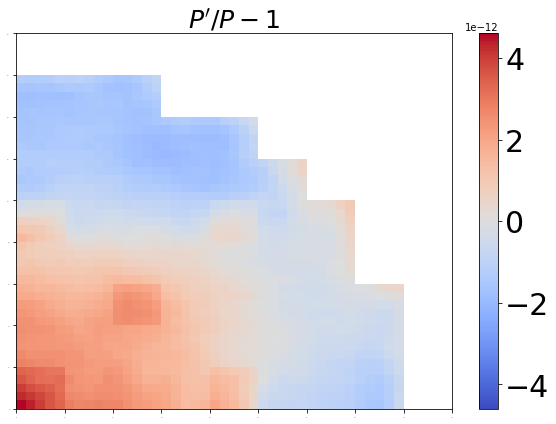

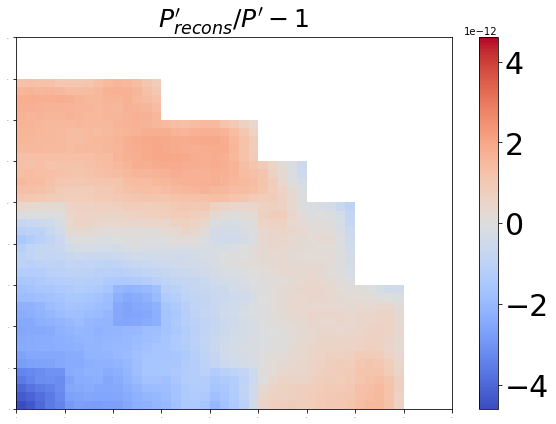

time: 1min 55s (started: 2022-09-28 11:18:13 +02:00)


In [ ]:
set_log_level(log_level.debug)
_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_refl, "PhiStarMPhi")

plot_delta(s, s_recons_refl, s_pert_refl)

In [ ]:
mat_lib_pert = mat.Materials(mat_lib)
sigf = mat_lib_pert.getValue("refl", 1, "2")*1.01
mat_lib_pert.setValue("refl", 1, "2", sigf)

macrolib_pert = mat.Macrolib(mat_lib_pert, pblm)
s_pert_refl2 = solver.SolverFullSlepc(x_mesh, y_mesh, z_mesh,
                            macrolib_pert, 1., 0., 1., 0., 0., 0.)
s_pert_refl2.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_refl2 = solver.SolverFullSlepc(s_pert_refl2)

[2022-09-28 11:20:10.329] [debug] Solver : krylovschur
[2022-09-28 11:20:10.329] [debug] Inner solver : 
[2022-09-28 11:20:10.329] [debug] Inner precond : 
[2022-09-28 11:20:10.329] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-09-28 11:20:10.329] [debug] Tolerance in inner iteration : 1.00e-03
[2022-09-28 11:20:10.329] [debug] Max. outer iteration : 500
[2022-09-28 11:20:10.329] [debug] Max. inner iteration : 10
[2022-09-28 11:25:32.808] [info] Number of converged eigenpairs: 1
[2022-09-28 11:25:32.808] [debug] Number of outter iteration: 10
[2022-09-28 11:25:32.808] [debug] Slepc converged reason: tolerance
[2022-09-28 11:25:32.818] [info] Eigen value 0 = 1.02141 +- 6.87e-06
time: 5min 23s (started: 2022-09-28 11:20:09 +02:00)


a0 =  0.999996921793926


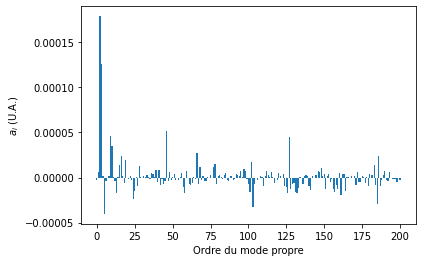

vp recons =  1.021410273946431
vp pert =  1.0214103571187576
vp ref =  1.021416562207763
sens -0.5947642586356725
sens recons -0.6027364620420936
delta recons -0.007972203406421088
pert/ref - 1 (min, max) :  -2.7482686974940407 0.6111720509201752 -0.24482137530442996 0.5418831705753318
recons/pert - 1 (min, max) :  -0.5328033427952167 2.867885500495913 0.27180359489760253 0.5518483466631089
pert_2d/ref_2d - 1 (min, max) :  -0.5104382989164974 0.1377147597013084 -0.09555429989506105 0.17647225871468233
recons_2d/ref_2d - 1 (min, max) :  -0.1394289514024347 0.5553859910385955 0.10682037191569217 0.1925552279475972
power pert/ref - 1 (min, max) :  -0.2814875720927239 0.41744010342604626 0.014414488050590766 0.0684711987749977
power recons/pert - 1 (min, max) :  -0.33297702123064365 0.23077895817536742 -0.0016220623362880613 0.05654817852405042
power pert_2d/ref_2d - 1 (min, max) :  -0.04131536240160336 0.19236468172250434 0.0023615153942180478 0.03746912420163989
power recons_2d/ref_2d - 

/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


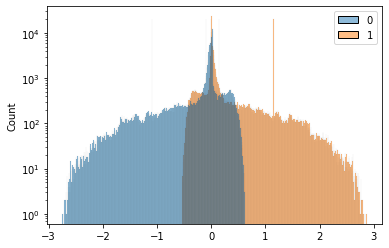

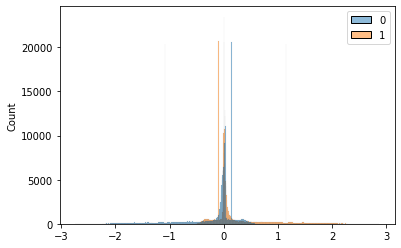

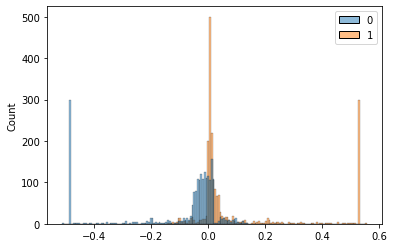

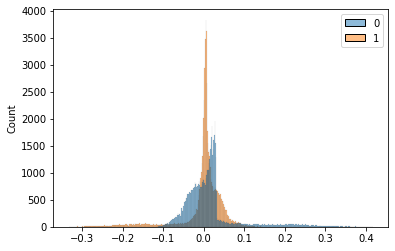

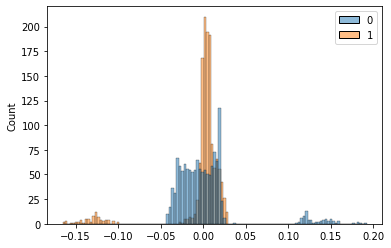

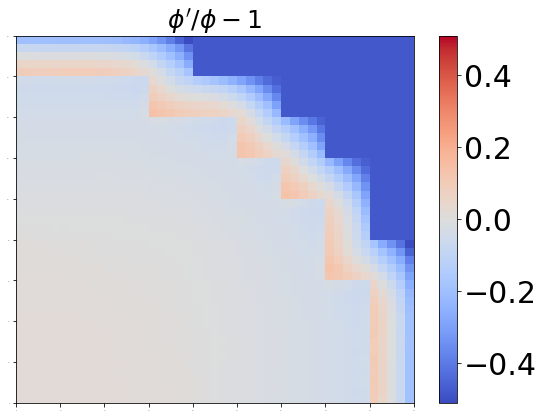

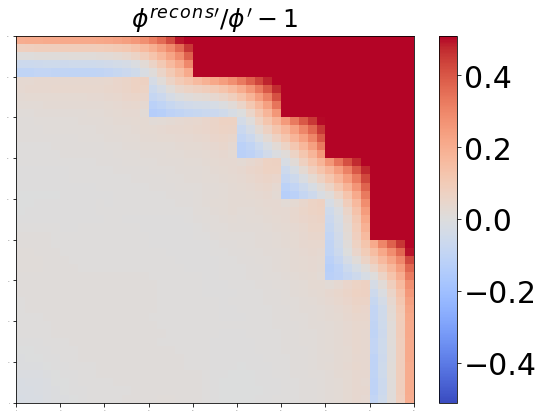

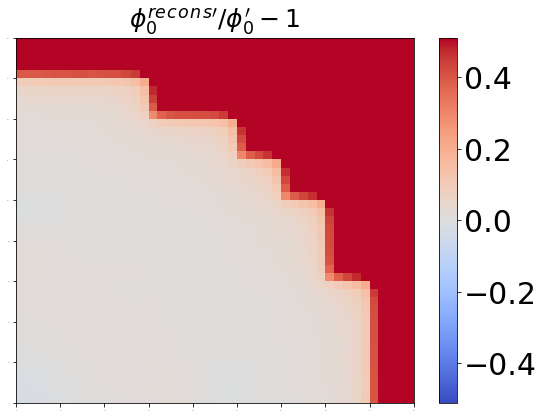

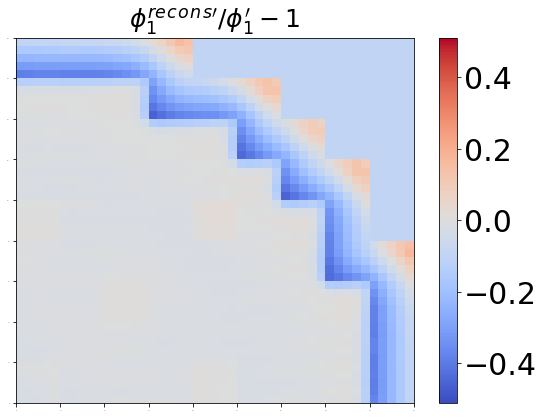

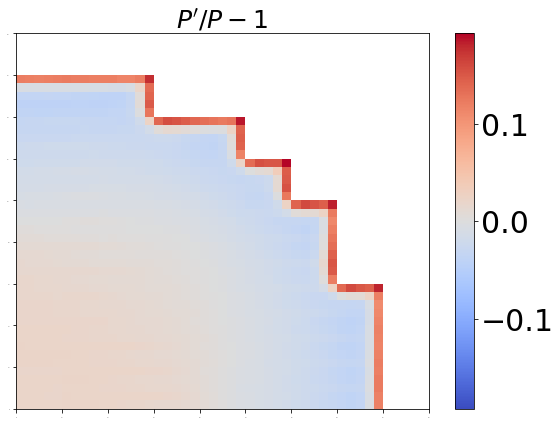

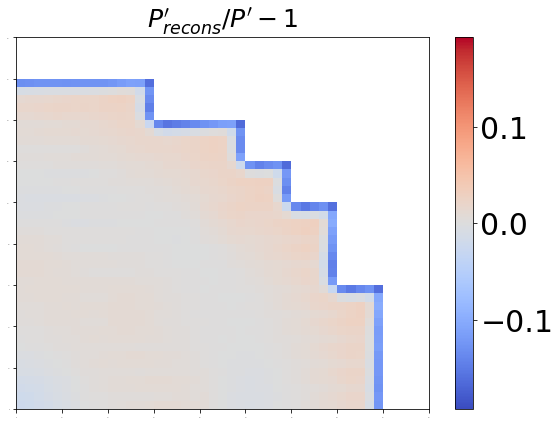

time: 16.2 s (started: 2022-09-28 11:25:32 +02:00)


In [ ]:
set_log_level(log_level.debug)
_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_refl2, "PhiStarMPhi")

plot_recons_coeff(a)
re_refl,  re_power_refl, delta_refl, delta_power_refl, delta_recons_refl, delta_recons_power_refl = plot_delta(s, s_recons_refl2, s_pert_refl2)

## Rod insertion perturbation 

In [ ]:
z_mesh_pert = [[0., 5, 10, 13, 16, 18, 19, 20.],
          [21, 22, 24, 27, 30., 35, 40, 50, 60, 70, 80, 90, 100.,
               110., 120., 130., 140., 150., 160., 170., 180., 190., 200.,
               210, 220, 230, 240, 250, 260, 265, 270., 273, 276],
          [278, 279, 280, 281, 282, 284, 287, 300, 305, 310, 320, 330, 340, 345, 350, 353, 356, 358, 359, 360], 
          [361, 362, 364, 367, 370, 375, 380.]]
z_mesh_r = z_mesh_pert       
pblm_pert = []
for pblm_i, z_mesh_i in zip([pblm3, pblm2, pblm1, pblm0], z_mesh_r):
    shape = (1, pblm_i.shape[0]*nb_div_pmat_y, pblm_i.shape[1]*nb_div_pmat_x)
    geom = np.empty(shape, dtype='U16')
    for i, row in enumerate(pblm_i):
        for j, value in enumerate(row):
            geom[0, i*nb_div_pmat_x:(i+1)*nb_div_pmat_x, j *
                nb_div_pmat_y:(j+1)*nb_div_pmat_y] = value
    for k in range(len(z_mesh_i)):
        if z_mesh_i[k] == 0.:
            continue
        pblm_pert.append(geom)
pblm_pert = np.concatenate(pblm_pert, axis=0)

macrolib_pert = mat.Macrolib(mat_lib, pblm_pert)

s_pert_rod = solver.SolverFullSlepc(x_mesh, y_mesh, z_mesh,
                            macrolib_pert, 1., 0., 1., 0., 0., 0.)
s_pert_rod.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_rod = solver.SolverFullSlepc(s_pert_rod)

[2022-09-28 11:25:49.876] [debug] Solver : krylovschur
[2022-09-28 11:25:49.876] [debug] Inner solver : 
[2022-09-28 11:25:49.876] [debug] Inner precond : 
[2022-09-28 11:25:49.876] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-09-28 11:25:49.876] [debug] Tolerance in inner iteration : 1.00e-03
[2022-09-28 11:25:49.876] [debug] Max. outer iteration : 500
[2022-09-28 11:25:49.876] [debug] Max. inner iteration : 10
[2022-09-28 11:31:12.719] [info] Number of converged eigenpairs: 1
[2022-09-28 11:31:12.719] [debug] Number of outter iteration: 10
[2022-09-28 11:31:12.719] [debug] Slepc converged reason: tolerance
[2022-09-28 11:31:12.730] [info] Eigen value 0 = 1.02084 +- 6.92e-06
time: 5min 23s (started: 2022-09-28 11:25:49 +02:00)


a0 =  0.9994610827492422


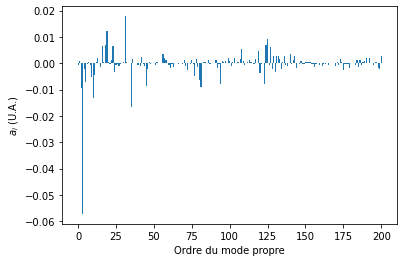

vp recons =  1.0203156441965957
vp pert =  1.020836304225087
vp ref =  1.021416562207763
sens -55.649609554658674
sens recons -105.63735914923598
delta recons -49.98774959457729
pert/ref - 1 (min, max) :  -55.049501999924054 4.304813202418554 1.6768401093317808 2.554990709019113
recons/pert - 1 (min, max) :  -56.60193496247619 32.72693189373597 1.3366094258689638 4.361428880256122
pert_2d/ref_2d - 1 (min, max) :  -10.024860562517677 2.797441945608404 0.7994089002575746 2.2851901299615625
recons_2d/ref_2d - 1 (min, max) :  -9.61885004229642 3.350521407390592 0.5709511994322796 2.233639098505578
power pert/ref - 1 (min, max) :  -55.04950199992407 4.296709219747198 1.0611131841267152 3.3696257700234717
power recons/pert - 1 (min, max) :  -46.59016360391466 29.28915245104227 0.8121805521922659 4.123064557409427
power pert_2d/ref_2d - 1 (min, max) :  -11.930283852860816 2.7830804184274114 -0.008722465610132023 2.692904578541652
power recons_2d/ref_2d - 1 (min, max) :  -9.426804446353133 3.1

/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


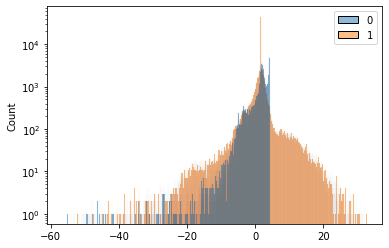

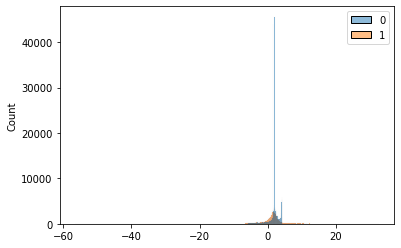

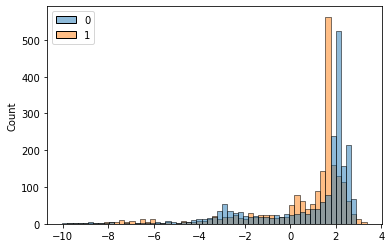

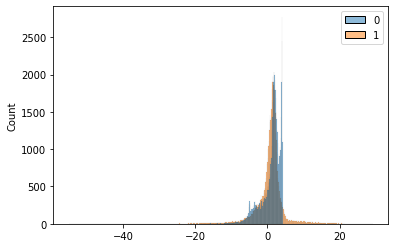

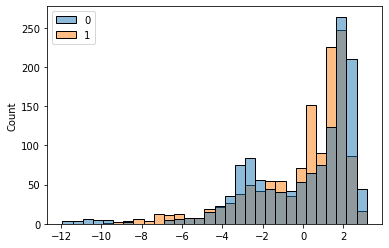

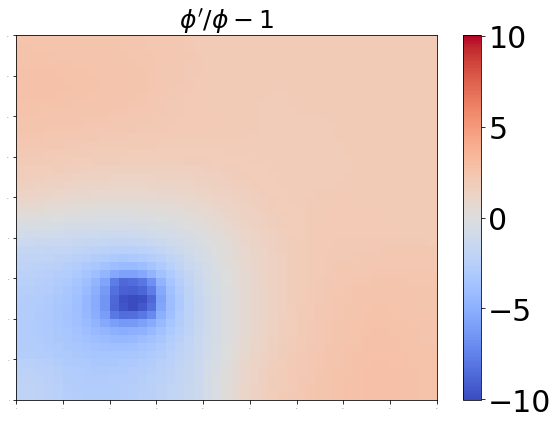

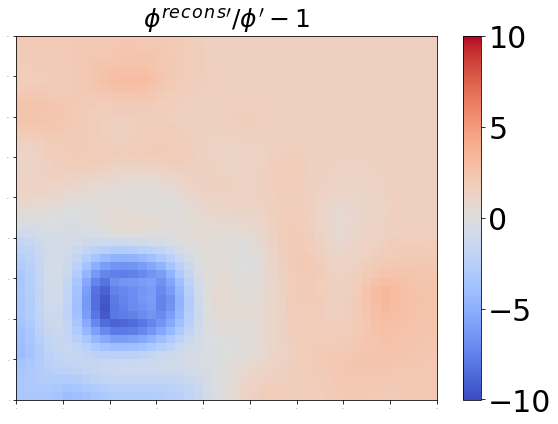

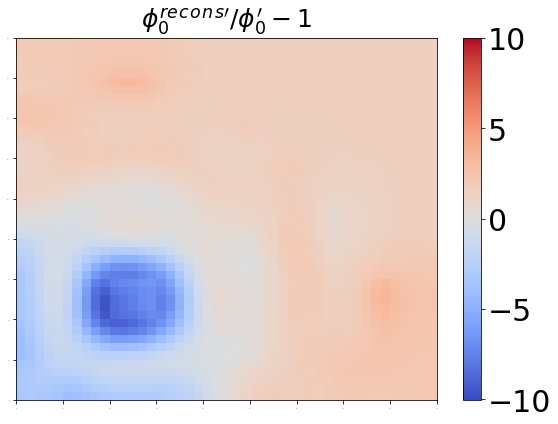

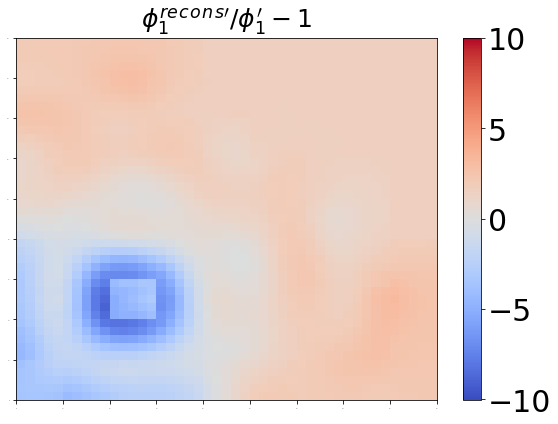

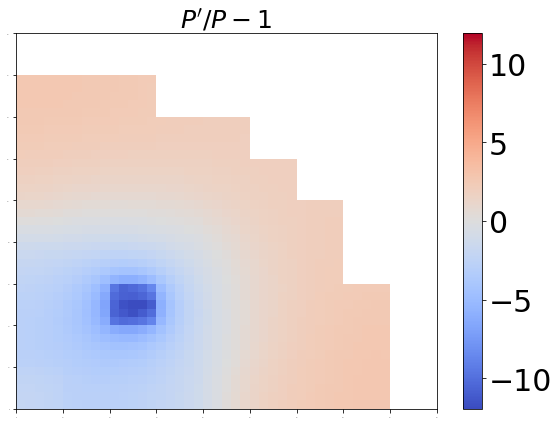

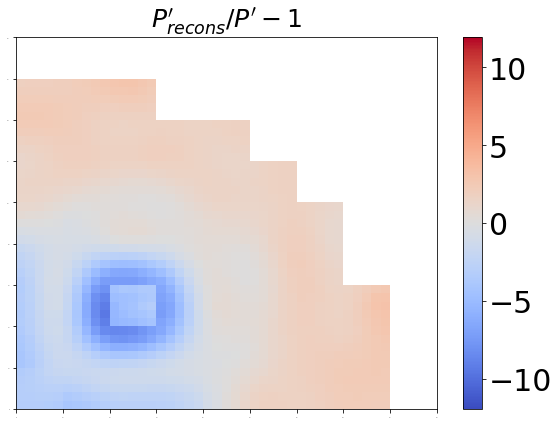

time: 24.8 s (started: 2022-09-28 11:31:12 +02:00)


In [ ]:
_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_rod, "PhiStarMPhi")

plot_recons_coeff(a)
re_rod,  re_power_rod, delta_rod, delta_power_rod, delta_recons_rod, delta_recons_power_rod = plot_delta(s, s_recons_rod, s_pert_rod)

vp recons =  1.0207436029879087
vp pert =  1.020836304225087
vp ref =  1.021416562207763
sens -55.649609554658674
sens recons -64.54597791308065
delta recons -8.896368358421958
pert/ref - 1 (min, max) :  -55.049501999924075 4.304813202418528 1.676840109331759 2.5549907090191124
recons/pert - 1 (min, max) :  -35.9626684547455 60.80046262356759 0.3133766421547139 2.4223756968619274
pert_2d/ref_2d - 1 (min, max) :  -10.024860562517697 2.7974419456083752 0.7994089002575528 2.285190129961562
recons_2d/ref_2d - 1 (min, max) :  -3.330719103847281 1.2677637829923023 0.10472477785143892 0.6630600181460132
power pert/ref - 1 (min, max) :  -55.049501999924075 4.296709219747169 1.0611131841266936 3.369625770023471
power recons/pert - 1 (min, max) :  -29.797456699237706 60.80046262356761 0.2118572486429685 2.3960578011975446
power pert_2d/ref_2d - 1 (min, max) :  -11.930283852860857 2.783080418427411 -0.008722465610153537 2.6929045785416514
power recons_2d/ref_2d - 1 (min, max) :  -3.14900407076623

/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


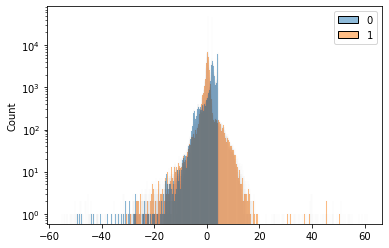

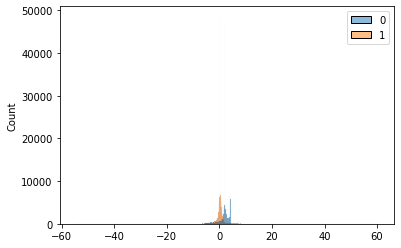

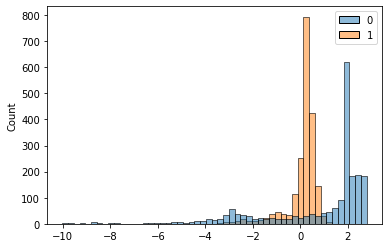

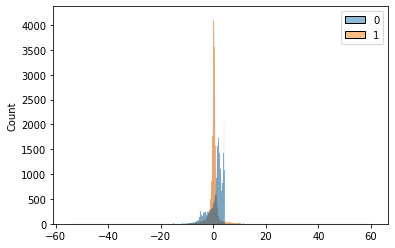

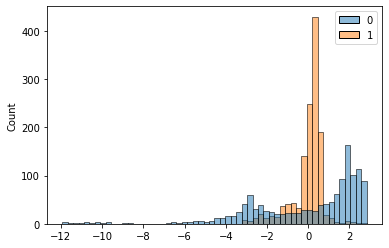

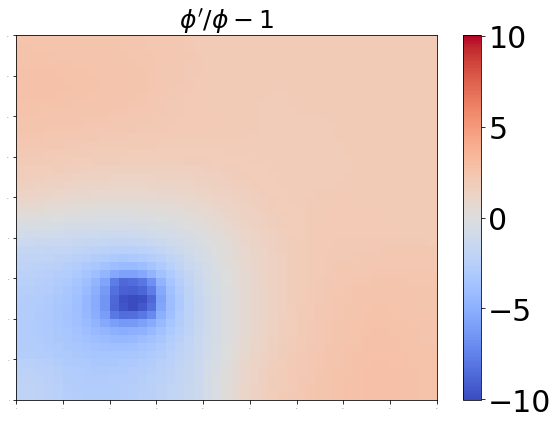

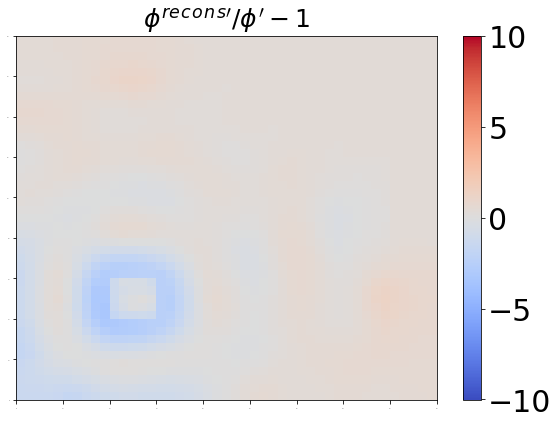

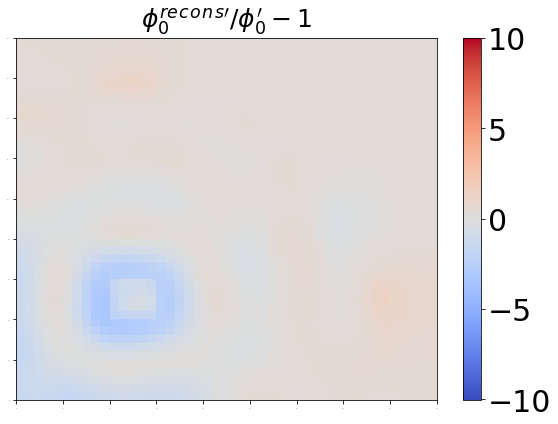

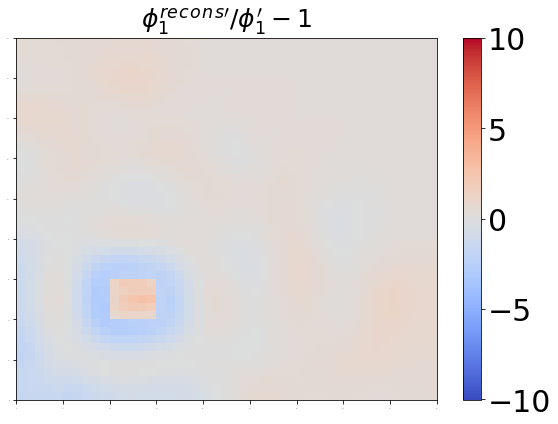

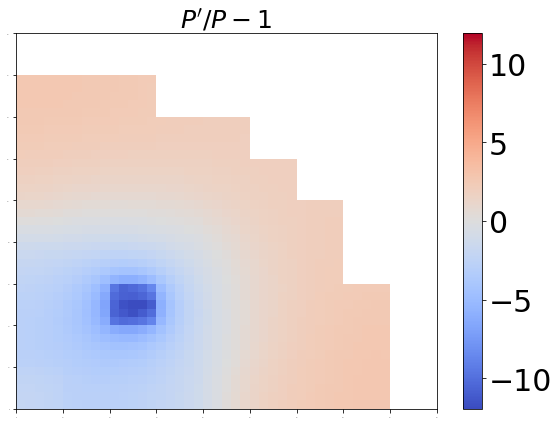

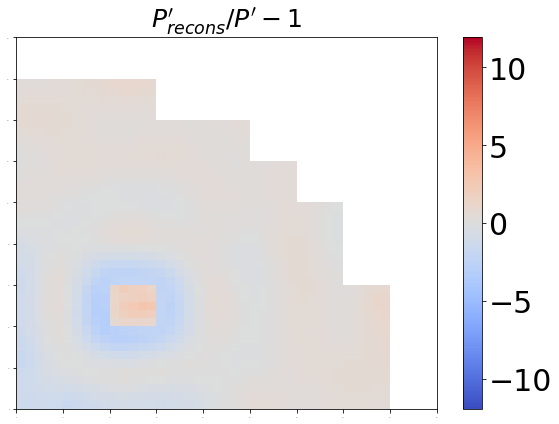

time: 13min 1s (started: 2022-09-28 11:31:37 +02:00)


In [ ]:
_, _, _ = pert.highOrderPerturbation(2, 
    s, s_star, s_recons_rod)

plot_delta(s, s_recons_rod, s_pert_rod)

## Modification of only one fuel assembly 

In [ ]:
fuel1 = [[1.5, 0.01, 0, 1, 0., 0.020, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.4, 0.085, 0.135*1.01, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
mat_lib.addMaterial(fuel1, "fuel1_pert", reac_names)

time: 1.48 ms (started: 2022-09-28 11:44:39 +02:00)


In [ ]:
x = [0, 20*9]
y = [0, 20*9]
z_delta = [0, 20., 260, 80, 20]
z = np.cumsum(z_delta)
pblm2 = np.array([["fuel1_cr", "fuel1",    "fuel1",    "fuel1",    "fuel1_cr", "fuel1",    "fuel1",    "fuel2",   "refl"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel2",   "refl"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel2",    "fuel2",   "refl"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1_pert",    "fuel1",    "fuel1",    "fuel2",    "refl",    "refl"],
                ["fuel1_cr", "fuel1",    "fuel1",    "fuel1",    "fuel1_cr", "fuel2",    "fuel2",    "refl",    "void"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel2",    "fuel2",    "refl",     "refl",    "void"],
                ["fuel1",    "fuel1",    "fuel2",    "fuel2",    "fuel2",    "refl",     "refl",     "void",    "void"],
                ["fuel2",    "fuel2",    "fuel2",    "refl",     "refl",     "refl",     "void",     "void",    "void"],
                ["refl",     "refl",     "refl",     "refl",     "void",     "void",     "void",     "void",    "void"]])
pblm1 = np.array([["fuel1_cr", "fuel1",    "fuel1",    "fuel1",    "fuel1_cr", "fuel1",    "fuel1",    "fuel2",   "refl"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel2",   "refl"],
                ["fuel1",    "fuel1",    "fuel1_cr", "fuel1",    "fuel1",    "fuel1",    "fuel2",    "fuel2",   "refl"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1_pert",    "fuel1",    "fuel1",    "fuel2",    "refl",    "refl"],
                ["fuel1_cr", "fuel1",    "fuel1",    "fuel1",    "fuel1_cr", "fuel2",    "fuel2",    "refl",    "void"],
                ["fuel1",    "fuel1",    "fuel1",    "fuel1",    "fuel2",    "fuel2",    "refl",     "refl",    "void"],
                ["fuel1",    "fuel1",    "fuel2",    "fuel2",    "fuel2",    "refl",     "refl",     "void",    "void"],
                ["fuel2",    "fuel2",    "fuel2",    "refl",     "refl",     "refl",     "void",     "void",    "void"],
                ["refl",     "refl",     "refl",     "refl",     "void",     "void",     "void",     "void",    "void"]])

#we mesh it
pblm = []
z_mesh = [[0., 5, 10, 13, 16, 18, 19, 20.],
        [21, 22, 24, 27, 30., 35, 40, 50, 60, 70, 80, 90, 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200.,
        210, 220, 230, 240, 250, 260, 265, 270., 273, 276, 278, 279, 280],
        [281, 282, 284, 287, 300, 305, 310, 320, 330, 340, 345, 350, 353, 356, 358, 359, 360], 
        [361, 362, 364, 367, 370, 375, 380.]]
z_mesh_r = z_mesh
print()
for pblm_i, z_mesh_i in zip([pblm3, pblm2, pblm1, pblm0], z_mesh_r):
    shape = (1, pblm_i.shape[0]*nb_div_pmat_y, pblm_i.shape[1]*nb_div_pmat_x)
    geom = np.empty(shape, dtype='U16')
    for i, row in enumerate(pblm_i):
        for j, value in enumerate(row):
            geom[0, i*nb_div_pmat_x:(i+1)*nb_div_pmat_x, j *
                nb_div_pmat_y:(j+1)*nb_div_pmat_y] = value
    for k in range(len(z_mesh_i)):
        if z_mesh_i[k] == 0.:
            continue
        pblm.append(geom)
pblm = np.concatenate(pblm, axis=0)
x_mesh = np.linspace(x[0], x[1], pblm.shape[2]+1)
dx = x_mesh[1:]-x_mesh[:-1]
y_mesh = np.linspace(y[0], y[1], pblm.shape[1]+1)
dy = y_mesh[1:]-y_mesh[:-1]
z_mesh = np.array([y for x in z_mesh_r for y in x])
dz = z_mesh[1:]-z_mesh[:-1]
macrolib_pert = mat.Macrolib(mat_lib, pblm)

s_pert_fuel = solver.SolverFullSlepc(x_mesh, y_mesh, z_mesh,
                                macrolib_pert, 1., 0., 1., 0., 0., 0.)
s_pert_fuel.solve(tol=1e-15, nb_eigen_values=1, inner_max_iter=10, tol_inner=1e-3)

s_recons_fuel = solver.SolverFullSlepc(s_pert_fuel)


[2022-09-28 11:44:39.847] [debug] Solver : krylovschur
[2022-09-28 11:44:39.847] [debug] Inner solver : 
[2022-09-28 11:44:39.847] [debug] Inner precond : 
[2022-09-28 11:44:39.847] [debug] Tolerance in outter iteration (eigen value): 1.00e-15
[2022-09-28 11:44:39.847] [debug] Tolerance in inner iteration : 1.00e-03
[2022-09-28 11:44:39.847] [debug] Max. outer iteration : 500
[2022-09-28 11:44:39.847] [debug] Max. inner iteration : 10
[2022-09-28 11:50:04.186] [info] Number of converged eigenpairs: 1
[2022-09-28 11:50:04.186] [debug] Number of outter iteration: 10
[2022-09-28 11:50:04.186] [debug] Slepc converged reason: tolerance
[2022-09-28 11:50:04.195] [info] Eigen value 0 = 1.02167 +- 6.86e-06
time: 5min 25s (started: 2022-09-28 11:44:39 +02:00)


vp recons =  1.021659280843258
vp pert =  1.0216662820696694
vp ref =  1.021416562207763
sens 23.929913557913157
sens recons 23.25916618978235
delta recons -0.6707473681308063
pert/ref - 1 (min, max) :  -1.17029147226707 4.900094844924039 0.0003389667416230628 0.5722751883736408
recons/pert - 1 (min, max) :  -1.5894488063130237 1.636156314080581 -0.011112097106877585 0.15193611258825618
pert_2d/ref_2d - 1 (min, max) :  -0.9242450412567038 2.95920202469711 -0.13304365015766537 0.563866077136712
recons_2d/ref_2d - 1 (min, max) :  -0.5696492278702162 0.13972970635339282 -0.017982787566455088 0.0681264117045514
power pert/ref - 1 (min, max) :  -1.1677705456446723 5.85800602609836 0.12806044978778525 0.711185475707992
power recons/pert - 1 (min, max) :  -1.3202662165324521 1.450751785976944 0.008385090497140806 0.13243014741433654
power pert_2d/ref_2d - 1 (min, max) :  -0.919088614476615 3.9172792232973093 -0.015556506579576563 0.7389642756363821
power recons_2d/ref_2d - 1 (min, max) :  -0.

/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


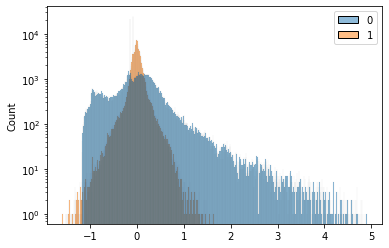

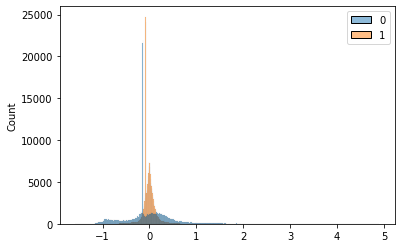

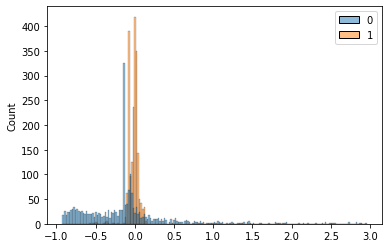

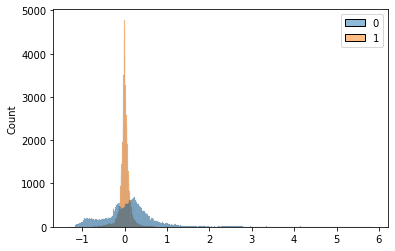

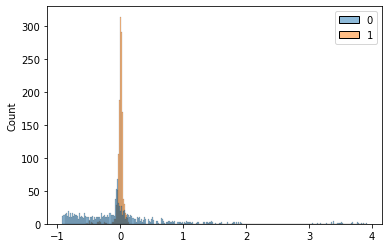

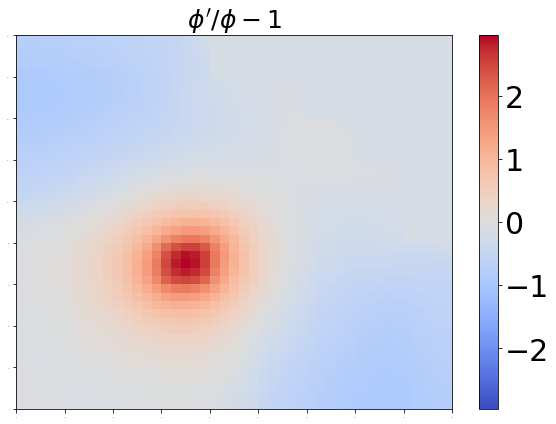

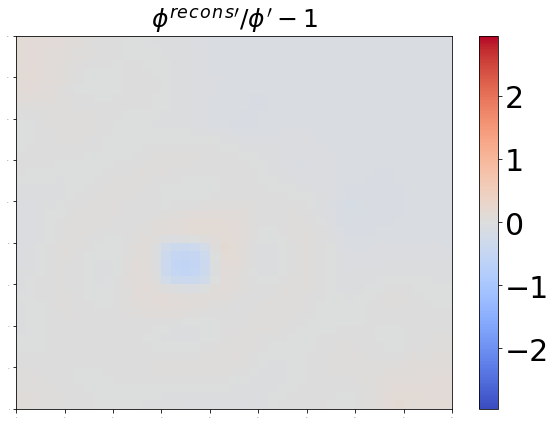

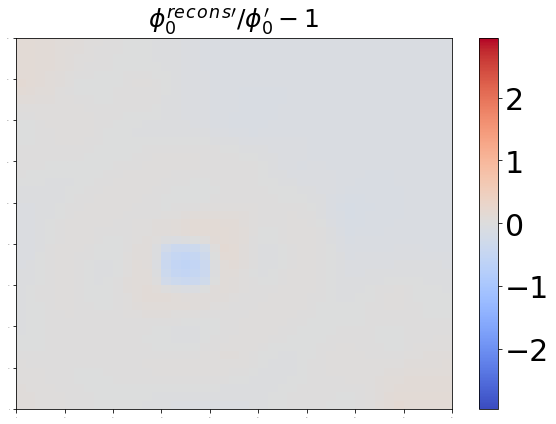

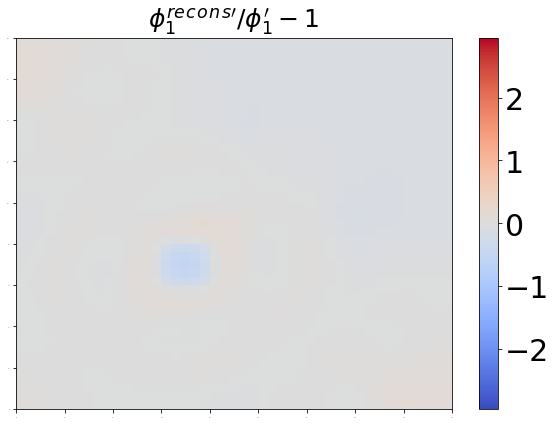

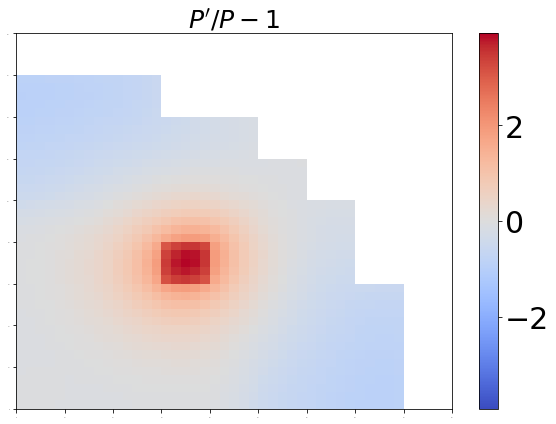

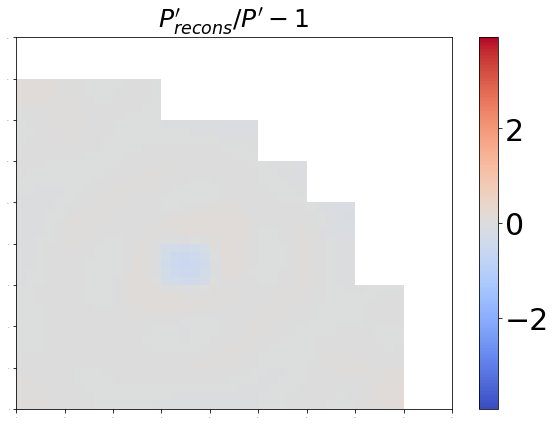

time: 17.6 s (started: 2022-09-28 11:50:04 +02:00)


In [ ]:
_, _, a = pert.firstOrderPerturbation(
    s, s_star, s_recons_fuel, "PhiStarMPhi")

re_sigf_ass,  re_power_sigf_ass, delta_sigf_ass, delta_power_sigf_ass, delta_recons_sigf_ass, delta_recons_power_sigf_ass = plot_delta(s, s_recons_fuel, s_pert_fuel)

vp recons =  1.0216652952284142
vp pert =  1.0216662820696694
vp ref =  1.021416562207763
sens 23.929913557913157
sens recons 23.835370510859942
delta recons -0.09454304705321202
pert/ref - 1 (min, max) :  -1.1702914722670477 4.900094844924057 0.0003389667416448372 0.5722751883736407
recons/pert - 1 (min, max) :  -1.680319139474507 1.6560133362023433 -0.020336806808636063 0.15538995836795982
pert_2d/ref_2d - 1 (min, max) :  -0.9242450412566898 2.95920202469711 -0.1330436501576436 0.5638660771367119
recons_2d/ref_2d - 1 (min, max) :  -0.5101355837064359 0.17658131382124967 -0.021396778494930695 0.06707270211617425
power pert/ref - 1 (min, max) :  -1.167770545644661 5.858006026098419 0.1280604497878064 0.7111854757079922
power recons/pert - 1 (min, max) :  -1.3999585271587265 1.4651160209342153 0.0009367950301443261 0.13459633038297864
power pert_2d/ref_2d - 1 (min, max) :  -0.919088614476571 3.917279223297309 -0.015556506579555303 0.7389642756363822
power recons_2d/ref_2d - 1 (min, max)

/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/ts249161/anaconda3/envs/opendiff/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


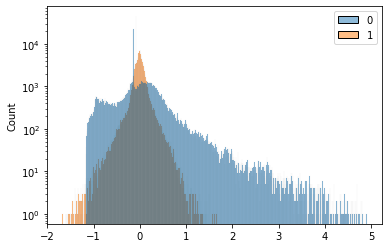

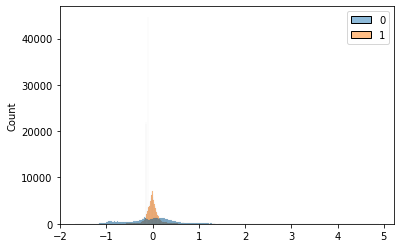

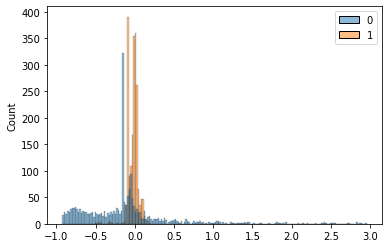

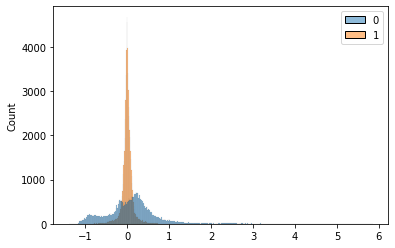

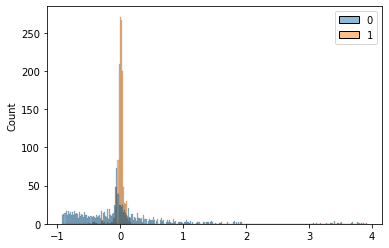

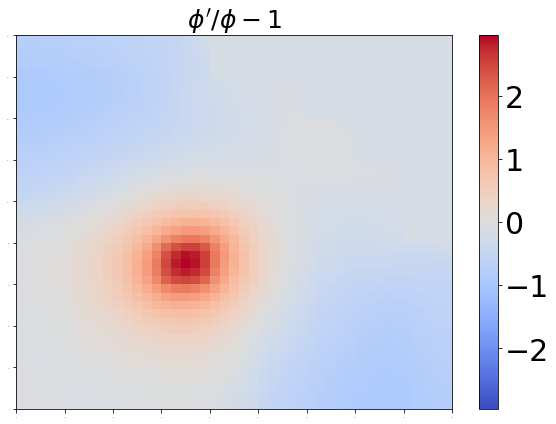

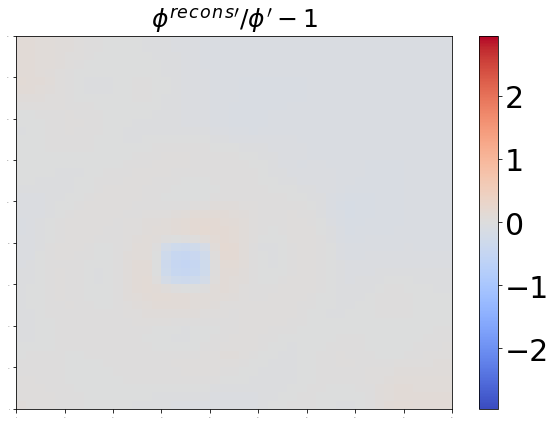

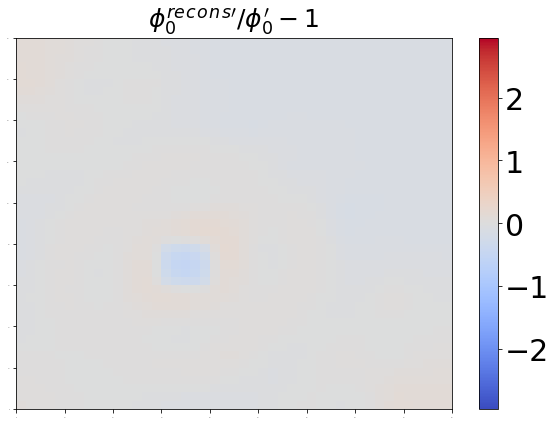

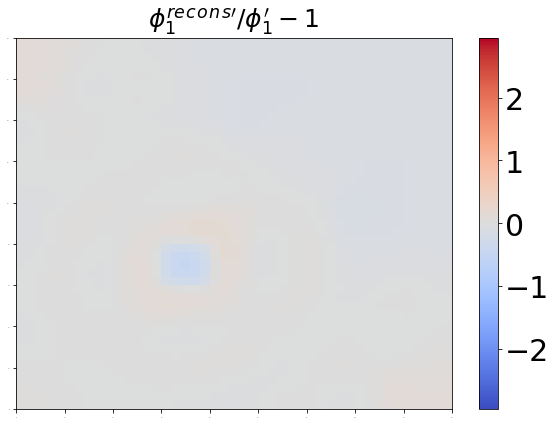

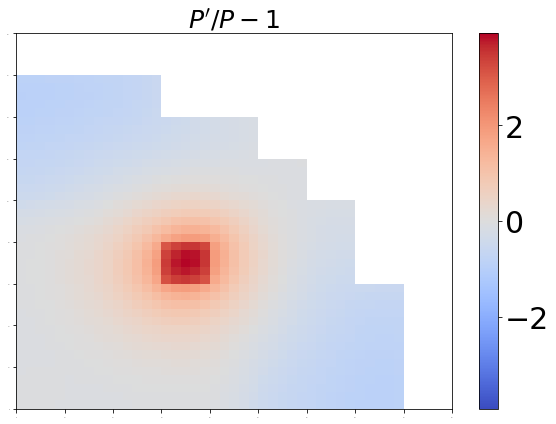

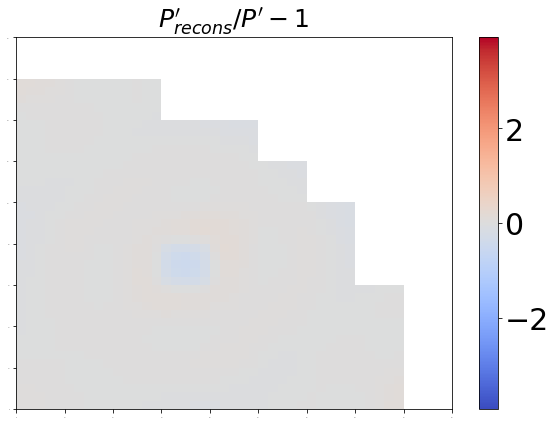

time: 12min 57s (started: 2022-09-28 11:50:21 +02:00)


In [ ]:
_, _, _ = pert.highOrderPerturbation(2, 
    s, s_star, s_recons_fuel)

plot_delta(s, s_recons_fuel, s_pert_fuel)

In [ ]:
print(f"\phi & {re_sigf:.3f} & {re_sigf_ass:.3f} & {re_sigr:.3f} & {re_rod:.3f} & {re_refl:.3f} \\\ \hline")
print(f"$Power$ & {re_power_sigf:.3f} & {re_power_sigf_ass:.3f} & {re_power_sigr:.3f} & {re_power_rod:.3f} & {re_power_refl:.3f} \\\ \hline")

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

sns.set(rc={'figure.figsize':(11.7, 8.27),
             "font.size": SMALL_SIZE, "axes.titlesize": SMALL_SIZE, "axes.labelsize": MEDIUM_SIZE,
             "xtick.labelsize": SMALL_SIZE, "ytick.labelsize": SMALL_SIZE,
             "legend.fontsize": SMALL_SIZE, "figure.titlesize": BIGGER_SIZE})

iterables = [["Fission", "Fission - one assembly", "Removal"], ["$\phi$", "P"]]
index = pd.MultiIndex.from_product(iterables, names=["first", "second"])
D_kl = pd.DataFrame([re_sigf, re_power_sigf,
                     re_sigf_ass, re_power_sigf_ass,
                     re_sigr, re_power_sigr],
                     index=index)
D_kl = D_kl.unstack([0, 1]).to_frame().reset_index([-1, -2])
D_kl.columns = ["Case", "", "$D_{KL}$"]
# print(D_kl)
ax = sns.catplot(
    data=D_kl, kind="bar",
    x="Case", y="$D_{KL}$", hue="",
    errorbar="sd", palette="dark", alpha=.6, height=7
)
ax.set(xlabel=None)
plt.show()


iterables = [["Rod", "Refl"], ["$\phi$", "P"]]
index = pd.MultiIndex.from_product(iterables, names=["first", "second"])
D_kl = pd.DataFrame([re_rod, re_power_rod,
                     re_refl, re_power_refl],
                     index=index)
D_kl = D_kl.unstack([0, 1]).to_frame().reset_index([-1, -2])
D_kl.columns = ["Case", "", "$D_{KL}$"]
# print(D_kl)
ax = sns.catplot(
    data=D_kl, kind="bar",
    x="Case", y="$D_{KL}$", hue="",
    errorbar="sd", palette="dark", alpha=.6, height=7
)
ax.set(xlabel=None)
plt.show()
ax.set(xlabel=None)
plt.show()
             
iterables = [["Fission", "Fission - one assembly", "Removal", "Rod", "Refl"], ["Perturbation", "Reconstruction"]]
index = pd.MultiIndex.from_product(iterables, names=["first", "second"])

data = pd.DataFrame([delta_sigf.flatten()/3., delta_recons_sigf.flatten()/3.,
                     delta_sigf_ass.flatten(), delta_recons_sigf_ass.flatten(),
                     delta_sigr.flatten(), delta_recons_sigr.flatten(),
                     delta_rod.flatten()/12., delta_recons_rod.flatten()/12., 
                     delta_refl.flatten(), delta_recons_refl.flatten()],
                     index=index)
data = data.unstack([0, 1]).to_frame().reset_index([-1, -2])
data.columns = ["Case", "", "$\phi'/\phi -1$"]

data_power = pd.DataFrame([delta_power_sigf.flatten()/3., delta_recons_power_sigf.flatten()/3.,
                           delta_power_sigf_ass.flatten(), delta_recons_power_sigf_ass.flatten(),
                           delta_power_sigr.flatten(), delta_recons_power_sigr.flatten(),
                           delta_power_rod.flatten()/12., delta_recons_power_rod.flatten()/12., 
                           delta_power_refl.flatten(), delta_recons_power_refl.flatten()],
                           index=index)
data_power = data_power.unstack([0, 1]).to_frame().reset_index([-1, -2])
data_power.columns = ["Case", "", "$P'/P -1$"]


ax = sns.boxplot(data=data, x="Case", y="$\phi'/\phi -1$", hue="")
ax.set(xlabel=None)
plt.show()

ax = sns.boxplot(data=data_power, x="Case", y="$P'/P -1$", hue="")
ax.set(xlabel=None)
plt.show()